<a href="https://colab.research.google.com/github/aypy01/tensorflow/blob/main/module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module-2



## Regression vs Classification

### 1. Look at the Target (y_train)

- **Continuous numbers (infinite possible values)** → Regression  
  - Examples: house price, temperature, stock return  

- **Categories / labels (finite set of values)** → Classification  
  - Examples: spam (yes/no), disease (present/absent), flower species  


### 2. Binary vs Multi-Class

- **Binary classification** → only 2 categories (0/1, yes/no)  
- **Multi-class classification** → more than 2 categories (digits 0–9, iris species)  



### 3. Inputs vs Target

- Inputs (X) are usually numeric after preprocessing.  
- What matters is the **target (y)**:  
  - Continuous → Regression  
  - Finite categories (0,1,2…) → Classification  


### 4. One-Line Rule

- If the question is **"How much?"** → Regression  
- If the question is **"Which class?"** or **"Yes/No?"** → Classification  


## Binary Clasification

In this section, we implement a simple linear regression model using TensorFlow on the Titanic dataset. Our goal is to predict whether a passenger survived the Titanic disaster based on various features like age, sex, class, etc.

### What You'll Learn:
- How to load and explore real-world datasets using Pandas
- How to handle categorical and numerical features separately
- How to preprocess data using scaling and one-hot encoding
- How to build a binary classification model using TensorFlow's Keras API
- How to evaluate model performance with accuracy and loss

>  not regression its classification, Linear Regression here is applied for binary classification, using a sigmoid output to predict probabilities of survival (0 or 1).


###Loading dataset

In [224]:
import tensorflow as tf
#tf.__version__
import pandas as pd

#At this point, it includes all columns (features + target survived).
x_train=pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv") #Training data
y_train=x_train.pop("survived") #y_train → labels (the target: 0 = not survived, 1 = survived), thee will be no target intrainng se

x_test=pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv") #Testing set
y_test=x_test.pop("survived")



In [225]:
x_train.drop(['fare'], axis=1, inplace=True)
# axis=0 → rows, axis=1 → columns
# inplace=True → modifies x_train directly (changes persist until you reload the CSV)

x_train.head()


,sex,age,n_siblings_spouses,parch,class,deck,embark_town,alone
0,male,22.0,1,0,Third,unknown,Southampton,n
1,female,38.0,1,0,First,C,Cherbourg,n
2,female,26.0,0,0,Third,unknown,Southampton,y
3,female,35.0,1,0,First,C,Southampton,n
4,male,28.0,0,0,Third,unknown,Queenstown,y


In [226]:
#Similarly for x_test
x_test.drop(['fare'],axis=1,inplace=True)
x_test.head()


,sex,age,n_siblings_spouses,parch,class,deck,embark_town,alone
0,male,35.0,0,0,Third,unknown,Southampton,y
1,male,54.0,0,0,First,E,Southampton,y
2,female,58.0,0,0,First,C,Southampton,y
3,female,55.0,0,0,Second,unknown,Southampton,y
4,male,34.0,0,0,Second,D,Southampton,y


In [227]:
#To get the whole table total description
x_train.describe()


,age,n_siblings_spouses,parch
count,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585
std,12.511818,1.151090,0.792999
min,0.750000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,35.000000,1.000000,0.000000
max,80.000000,8.000000,5.000000


In [228]:
#Lets use th shape function in this
x_train.shape

(627, 8)

We have 627 inputs features and 8 labels

In [229]:
#Now seeing whats inside our y_train
y_train.head()
#0= not survided, 1= survived


,survived
0,0
1,1
2,1
3,1
4,0


###Visuals of above data(optional)

<Axes: >

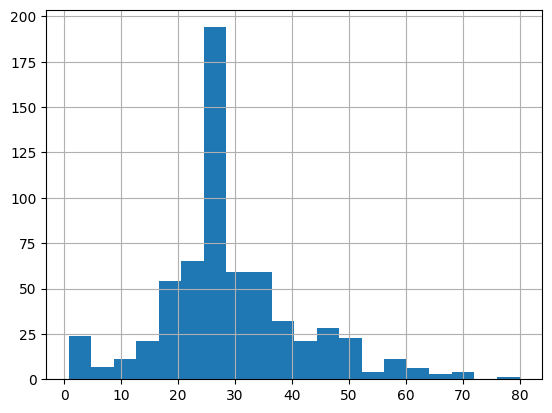

In [230]:
#Best for multi representation hist(bins=20)
x_train['age'].hist(bins=20)

seeing most of the population is b/w 20,30s
Also the outliers are there like there 80

<Axes: xlabel='sex'>

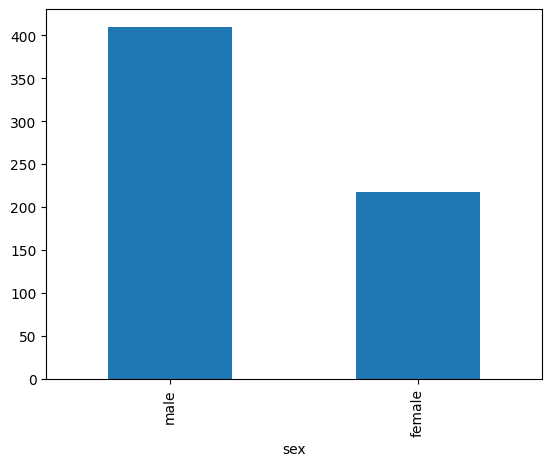

In [231]:
#Best for binary value_counts().plot(kind='barh')
x_train['sex'].value_counts().plot(kind='bar')

<Axes: xlabel='class'>

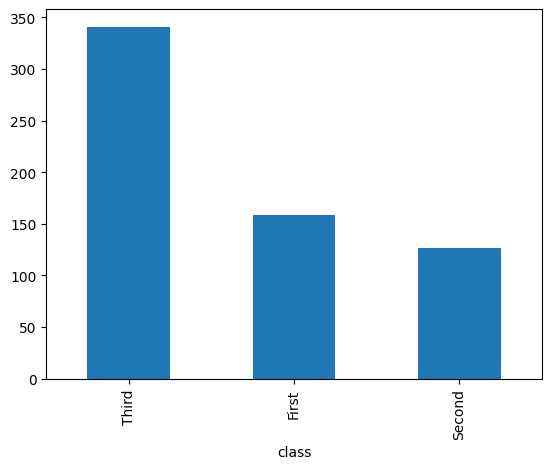

In [232]:
#x_train.class.pd.value_counts().plot(kind='barh')
x_train['class'].value_counts().plot(kind='bar')
#Class here is the status

We now got the info of :

*   Most passengers are in 20-30



*   Male and female proportion


*   number of people in classes

As seen the scaling of these are needed otherwise while training the model will take these things more important feature than other.



###Training vs Testing

Every machine learning workflow involves splitting the dataset into **training** and **testing** sets. This is a crucial step.

### Why Split the Data?

- The **training set** is used to teach the model. It learns patterns, weights, and relationships from this data.
- The **testing set** is used to evaluate how well the model has learned — basically, how it performs on data it hasn't seen before.

If we were to evaluate the model on the same data it trained on, the accuracy would be misleading. The model might just memorize the data rather than actually learning how to generalize. This is known as **overfitting**.

### About the Dataset

In the Titanic dataset:
- There are two types of features:
  1. **Categorical**: These are text-based, like `sex`, `embark_town`, etc.
  2. **Numerical**: These are already in number form, like `age`, `fare`, etc.

Before feeding the data to the model:
- We need to convert the **categorical features** into **numerical values**. For example:  
  `male → 1`, `female → 0`,


###Preprocessing & Scaling

Before we train a machine learning model, we need to **prepare the data properly**. Raw data isn't usually clean or in the right format for training.

### 1. Categorical Features → Numerical (Encoding)

Some columns contain text values — for example:
- `sex` → "male", "female"
- `class` → "First", "Second", "Third"

Since ML models work with numbers, we need to convert these to a numerical format. This is done through **One-Hot Encoding**:
- It creates a new column for each unique value in a category.
- Example:
  - "male" and "female" become two columns: `sex_male`, `sex_female`
  - Each row will have either a `1` or `0` depending on the original value.

We use `pandas.get_dummies()` to do this.

### 2. Numerical Features → Scaled (Standardization)

Columns like `age` and `fare` have numerical values, but their ranges can vary a lot.  
We use **StandardScaler** to normalize them:
- It transforms the data so that it has:
  - Mean = 0
  - Standard Deviation = 1

This helps the model **train faster and more effectively**, especially for algorithms like logistic regression or neural networks.



###Scaling/Encoding

####X-Train

In [233]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define columns
category_col = ['sex', 'class', 'deck', 'embark_town', 'alone']
numeric_col = ['age', 'n_siblings_spouses', 'parch']
#Why not i've did a Normalizer intead of scaler??
# Preprocessing/Scaling/Encoding the string into numerical value
x_train[numeric_col] = StandardScaler().fit_transform(x_train[numeric_col]) # Scaler on numerical as we seen that there huge age group of 20sto 30s so model should not just focus on that
x_train_encoded = pd.get_dummies(x_train[category_col + numeric_col])# One-hot encode categories in either 0 or 1 or true or false and do not youch he numerical value
#x_train_encoded is not only for just encoded but final concat in having both in the train like before
#re-index is there for test only or like this is correct?
x_train_encoded = x_train_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)
x_train_encoded.head(3)


,age,n_siblings_spouses,parch,sex_female,sex_male,class_First,class_Second,class_Third,deck_A,deck_B,...,deck_E,deck_F,deck_G,deck_unknown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown,alone_n,alone_y
0,-0.610415,0.395198,-0.479053,False,True,False,False,True,False,False,...,False,False,False,True,False,False,True,False,True,False
1,0.669397,0.395198,-0.479053,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,-0.290462,-0.474238,-0.479053,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True


In [234]:
x_train_encoded.shape
#See after scaling the shape is changed in column

(627, 22)

####X-Test

In [235]:
# Now preprocess x_test similarly
x_test[numeric_col] = StandardScaler().fit_transform(x_test[numeric_col])  # Same scaler for consistency
x_test_encoded = pd.get_dummies(x_test[category_col + numeric_col])  # One-hot encode categories
x_test_encoded.head()


,age,n_siblings_spouses,parch,sex_female,sex_male,class_First,class_Second,class_Third,deck_A,deck_B,...,deck_D,deck_E,deck_F,deck_unknown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown,alone_n,alone_y
0,0.444353,-0.480982,-0.462054,False,True,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
1,1.788943,-0.480982,-0.462054,False,True,True,False,False,False,False,...,False,True,False,False,False,False,True,False,False,True
2,2.072015,-0.480982,-0.462054,True,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,1.859711,-0.480982,-0.462054,True,False,False,True,False,False,False,...,False,False,False,True,False,False,True,False,False,True
4,0.373585,-0.480982,-0.462054,False,True,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True


In [236]:
#reindex is only for test coz we do not wan tthere should be any unseenlabel while testing
x_test_encoded = x_test_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)

In [237]:
x_train_encoded.shape

(627, 22)

###Model

In [238]:
# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train_encoded.shape[1],)), # [1] = input neurons ,used to have 8 now 22 due scaled
    tf.keras.layers.Dense(64, activation='relu'),#2nd Layer
    tf.keras.layers.Dense(16, activation='relu'),#3rd Layer
    tf.keras.layers.Dense(1, activation='sigmoid') #Output Layery
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###Compile

Once our model architecture is defined, the next step is to **compile** it. This tells TensorFlow how the model should be optimized, how loss should be calculated, and what metrics to track.




In [239]:
# Compile & train
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy', #Good for binary classification
    metrics=['accuracy'],
      )


###Training


In [240]:
#Model.Fit
model.fit(x=x_train_encoded, y=y_train, epochs=20, batch_size=32,validation_split=0.2)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5389 - loss: 0.6776 - val_accuracy: 0.7460 - val_loss: 0.5518
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7108 - loss: 0.5758 - val_accuracy: 0.8413 - val_loss: 0.4368
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8002 - loss: 0.5017 - val_accuracy: 0.8492 - val_loss: 0.3528
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8098 - loss: 0.4323 - val_accuracy: 0.8571 - val_loss: 0.3338
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8182 - loss: 0.4302 - val_accuracy: 0.8810 - val_loss: 0.3267
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8439 - loss: 0.3944 - val_accuracy: 0.8810 - val_loss: 0.3182
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8358 - loss: 0.4374 - val_accuracy: 0.8810 - val_loss: 0.3294
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8362 - loss: 0.3967 - val_accuracy: 0.8651 - val_loss

###Evaluate

In [241]:
#Slicing in loss and accuracy
# Evaluate the model on the test data /unseen data

loss, accuracy = model.evaluate(x_test_encoded, y_test, verbose=2) #verbose is jsut more details in output


9/9 - 0s - 6ms/step - accuracy: 0.8144 - loss: 0.4316


###Predict

In [242]:
pred = model.predict(x_test_encoded)

#As our outpurt layer is sigmoid and have to classify in 0 and 1 a binary we mentiona a threshold of 0.5
# Convert probabilities to 0 or 1
pred_class = (pred > 0.5).astype("int32") #astype = makes boolean , like True and False and infrence that from threshold values i.e 0.5 here

print(pred[:5])        # raw probabilities
print()
print(pred_class[:5])  # converted to 0/1
#pred_class.head()
##See at index 4 and y_test index 4 are misclassifying due to the accuracy is not that good


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[0.15446499]
 [0.3410417 ]
 [0.9254699 ]
 [0.81389856]
 [0.15139951]]

[[0]
 [0]
 [1]
 [1]
 [0]]


In [243]:
y_test.head()

,survived
0,0
1,0
2,1
3,1
4,1


###Saving Model

In [244]:
#Mopdel Save
model.save("regression.h5")

## Corrections & Checks

### Data Basics
- Correct: `x_train = features`, `y_train = labels` = Seen

### Training
- Correct: Training adjusts weights → compares with `y_train [labels]` → backpropagation → gradient descent

### Hidden Layers
- Correct: Multiple hidden layers = more computation  
- Note: More layers are not always better, depends on data

### Intuition
- Correct: Playground analogy: 4 quadrants → 4 neurons → classify regions

### Preprocessing
- Wrong: Categorical split/choice should be manual  
- Correct: Use `df.dtypes` or libraries  

- Correct: Scaling needed for numerical features to avoid dominance by large values  
- Correct: Encode categorical → concat with numerical → one dataset  

- Correct: Apply preprocessing on both train & test  
- Wrong: Reindex/fill should not be applied to train, only to test

### Train/Test Data
- Correct: Two common cases: separate files or split from one dataset

### Model Input
- Correct: Input shape = `(x_train_final.shape[1],)`

### Activations
- Correct: ReLU = hidden layers  
- Correct: Sigmoid = binary output  
- Correct: Tanh = -1 to 1 (less common now)

### Compile
- Correct: Loss = binary cross-entropy for 0/1  
- Correct: Optimizers = gradient-based (Adam, RMSProp)  
- Correct: Metrics = accuracy

### Fit
- Correct: Fit = epochs, validation, batch size  


### Evaluate
- Correct: `model.evaluate(x_test, y_test)`  
- Wrong: Do not mix `x_train` with `y_test`

### Predict
- Correct: `model.predict(x_test_encoded)` (not train set)

### Save
- Correct: Models saved as `.h5` or `SavedModel`


---
##**Multi-class Classification**
classifies data into categories or classes,
unlike regression which predicts a continuous numerical value.

In [245]:
#Importing libraries
#Flower daatset having name class and its length and witdh specifications

import tensorflow as tf
import pandas as pd


###Loading Dataset

In [246]:
#As the dataset is not arranged in this manner we have to make the col manually
col_name=['SepalLength','SepalWidth','PetalLength','PetalWidth','Species']#User mades labels
species_name=['Setosa','Versicolor','Virginica']#Usermade Targets

x_train=pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv",names=col_name,header=0)#Reading and making a representation in row and coloumn
y_train=x_train.pop('Species')

x_train.head()


,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [247]:

#Creating the target Species
x_test=pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv",names=col_name,header=0)
y_test=x_test.pop('Species')

x_train.head() ## see the target is remomed from training set now

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [248]:
y_train.head()

,Species
0,2
1,1
2,2
3,0
4,0


In [249]:
#Shape
x_train.shape


(120, 4)

In [250]:
#desribe
x_train.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,120.000000,120.000000,120.000000,120.000000
mean,5.845000,3.065000,3.739167,1.196667
std,0.868578,0.427156,1.822100,0.782039
min,4.400000,2.000000,1.000000,0.100000
25%,5.075000,2.800000,1.500000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.425000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


###Scaling/Normalization

In [251]:
import numpy as np

In [252]:
#Normalization
#As everything is numerical value in the dataset we will only do sclaing or Normalization
#Its like Standard Scaler kinda preprocessing
#from tensorflow.keras import layers

#Normalizer Layer = Scaler without Standard scaler of scikitlearn,its just from tensorflow
normalizer=tf.keras.layers.Normalization(axis=-1) #axis=-1 means “normalize along the last axis,” i.e., feature-wise, not sample-wise.

normalizer.adapt(np.array(x_train))




###Model
Model Architecture
The general architecture (layers, activations) can look similar for regression and classification,but the output layer and loss function differ based on the task.

In [253]:
from tensorflow.keras import layers

#Model
#Architecture for regression and clasification is the same
model=tf.keras.Sequential([normalizer,#this is input neuron , not need the input_shape(x_train) ,the adapt function does that already
                        layers.Dense(64,activation='relu'), #Hidden Layer 1
                        layers.Dense(32,activation='relu'), #Hidden Layer 2
                        layers.Dense(16,activation='relu'),  #Hidden Layer 3
                        layers.Dense(3,activation='softmax') #This is where the classifcation is diff from regression, Output layer is 'Classifying' in # class not like regression
                        ])


###Compile

In [254]:
#Model Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #good for multiple classification
              metrics=['accuracy']) #Defining the weight priority#Training


###Training

In [255]:

model.fit(x_train,y_train,epochs=10,validation_split=0.2,batch_size=32,verbose=1)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.3542 - loss: 1.2042 - val_accuracy: 0.3333 - val_loss: 1.2139
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4583 - loss: 1.0867 - val_accuracy: 0.3333 - val_loss: 1.1113
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4870 - loss: 0.9897 - val_accuracy: 0.3750 - val_loss: 1.0280
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5729 - loss: 0.9137 - val_accuracy: 0.8333 - val_loss: 0.9543
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7721 - loss: 0.8517 - val_accuracy: 0.8750 - val_loss: 0.8902
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8008 - loss: 0.7929 - val_accuracy: 0.8750 - val_loss: 0.8319
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7969 - loss: 0.7453 - val_accuracy: 0.8750 - val_loss: 0.7780
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7760 - loss: 0.6997 - val_accuracy: 0.8750 - val_loss: 0.7298

###Evaluate

In [256]:
# Evaluate the model on the test data
#for this the accuracy should be high
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'Accuracy= {accuracy:.03f}')
print(f'Loss={loss:.03f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7000 - loss: 0.6715
Accuracy= 0.700
Loss=0.672


###Predict

In [257]:
#Model.Predict
import numpy as np

prediction=model.predict(x_test)
#can't use astype coz its not binary but tirtiary classification and used a softmax activation as output
print(tf.argmax(prediction[1]).numpy()) # at index 1 its predicting 2;correct
print(prediction[0])
print(tf.argmax(prediction[2]).numpy())#at index 1 its predicting 0; correct
print(prediction[3])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2
[0.23427503 0.3197433  0.4459817 ]
0
[0.16206469 0.297829   0.5401063 ]


In [258]:
#To check above prediction
y_test.head()

,Species
0,1
1,2
2,0
3,1
4,1


###Saving model

In [259]:
#Saving the model
model.save("classification.h5")

---
## Navigation

###  Explore More Projects
[![Project: Sentiment Analysis](https://img.shields.io/badge/Project-Sentiment_Analysis-e6770b?style=for-the-badge&logo=github&logoColor=00FF80&labelColor=765898)](https://github.com/aypy01/tensorflow/blob/main/sentiments.ipynb)

###  Continue to Next Module
[![Module 03](https://img.shields.io/badge/Next-Module_03-e6770b?style=for-the-badge&logo=github&logoColor=00FF80&labelColor=765898)](https://github.com/aypy01/tensorflow/blob/main/module-3.ipynb)

---

## Author
 <p align="left">
  Created and maintained by &nbsp;
  <a href="https://github.com/aypy01" target="_blank">
  <img src="https://img.shields.io/badge/Aaditya_Yadav-aypy01-e6770b?style=flat-square&logo=github&logoColor=00FF80&labelColor=765898" alt="GitHub Badge"/>
</a>

</p>

<p>
<img src="https://readme-typing-svg.demolab.com?font=Fira+Code&duration=3000&pause=500&color=00FF80&background=765898&center=false&vCenter=false&width=440&lines=Break+Things+First%2C+Understand+Later;Built+to+Debug%2C+Not+Repeat;Learning+What+Actually+Sticks;Code.+Observe.+Refine." alt="Typing SVG" />
</p>


---

## License

This project is licensed under the [![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT).

---